# **Imports**

In [1]:
from requests import get
from json import dumps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable, Dict, Union, List
from http import HTTPStatus

# **Activity 1**

## **1.1 Sub-activity: Open Data COVID-19 API**

### **Task 1**

In [2]:
# Define a function to get covid data and the function allows us to add filter to define the specific type of area and user defined 
# structure to get the specific values that we want. Also, the function get data from all pages and return a list of dictionaries.
def get_API_data(filter, structure):
  
  # Library address
  ENDPOINT = "https://api.coronavirus.data.gov.uk/v1/data"

  # Transform filter type to a list
  filters = [
           "areaType={}".format(filter["areaType"])
]

  page_number = 1

  api_params = {
      "filters": str.join(";", filters),
      "structure": dumps(structure, separators=(",", ":")),
      "page": page_number
  }

  # paginated data
  data = list()

  page_number = 1

  while True:
      # Adding page number to query params
      api_params["page"] = page_number

      response = get(ENDPOINT, params=api_params, timeout=10)

      if response.status_code >= HTTPStatus.BAD_REQUEST:
          raise RuntimeError(f'Request failed: {response.text}')
      elif response.status_code == HTTPStatus.NO_CONTENT:
          break

      current_data = response.json()
      page_data: List[StructureType] = current_data['data']
      
      data.extend(page_data)

      # The "next" attribute in "pagination" will be None
      # when we reach the end.
      if current_data["pagination"]["next"] is None:
          break

      page_number += 1
  
  return data

### **Task 2**

In [3]:
# Call the function, and define filter and structure 
# Filter dictionary
filter1 = {"areaType": "nation"}
filter2 = {"areaType": "region"}

# Structure dictionary
structure = {
    "date": "date",
    "name": "areaName",
    "daily_cases": "newCasesBySpecimenDate",
    "cumulative_cases": "cumCasesBySpecimenDate",
    "daily_deaths": "newDeaths28DaysByPublishDate",
    "cumulative_deaths": "cumDeaths28DaysByPublishDate",
    "cumulative_vaccinated": "cumPeopleVaccinatedCompleteByVaccinationDate",
    "vaccination_age": "vaccinationsAgeDemographics"
}

# Get API data
results_json_national = get_API_data(filter1, structure)
results_json_regional = get_API_data(filter2, structure)

## **1.2 Sub-activity: Shaping the COVID data into different dataframes**


### **Task 3**

In [4]:
# Concatenate the two lists of dictionaries.
results_nation_region = results_json_national + results_json_regional  

### **Task 4**

In [5]:
# Transform the list to a dataframe called covid_data.
covid_data = pd.DataFrame(results_nation_region)
covid_data

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
0,2022-01-20,England,NaN,NaN,280.0,133245.0,NaN,[]
1,2022-01-19,England,46293.0,13255586.0,301.0,132965.0,40058085.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
2,2022-01-18,England,86128.0,13209293.0,400.0,132664.0,40034759.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
3,2022-01-17,England,100092.0,13123165.0,63.0,132264.0,40011668.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
4,2022-01-16,England,75667.0,13023073.0,79.0,132201.0,39990798.0,"[{'age': '12_15', 'VaccineRegisterPopulationBy..."
...,...,...,...,...,...,...,...,...
9104,2020-02-09,South East,1.0,6.0,NaN,NaN,NaN,[]
9105,2020-02-08,South East,4.0,5.0,NaN,NaN,NaN,[]
9106,2020-02-07,South East,0.0,1.0,NaN,NaN,NaN,[]
9107,2020-02-06,South East,0.0,1.0,NaN,NaN,NaN,[]


### **Task 5**

In [6]:
# Delete England because it is already in the regional portion.
covid_data.drop(covid_data[covid_data["name"] == "England"].index, inplace=True)
covid_data

,date,name,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
722,2022-01-20,Northern Ireland,NaN,NaN,2.0,3056.0,NaN,[]
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,NaN,[]
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,NaN,[]
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,NaN,[]
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,NaN,[]
...,...,...,...,...,...,...,...,...
9104,2020-02-09,South East,1.0,6.0,NaN,NaN,NaN,[]
9105,2020-02-08,South East,4.0,5.0,NaN,NaN,NaN,[]
9106,2020-02-07,South East,0.0,1.0,NaN,NaN,NaN,[]
9107,2020-02-06,South East,0.0,1.0,NaN,NaN,NaN,[]


### **Task 6**

In [7]:
# Rename the column of name to "area".
covid_data.rename(columns={'name':'area'}, inplace=True)
covid_data

,date,area,daily_cases,cumulative_cases,daily_deaths,cumulative_deaths,cumulative_vaccinated,vaccination_age
722,2022-01-20,Northern Ireland,NaN,NaN,2.0,3056.0,NaN,[]
723,2022-01-19,Northern Ireland,4180.0,496038.0,6.0,3054.0,NaN,[]
724,2022-01-18,Northern Ireland,4815.0,491858.0,6.0,3048.0,NaN,[]
725,2022-01-17,Northern Ireland,5048.0,487043.0,4.0,3042.0,NaN,[]
726,2022-01-16,Northern Ireland,3780.0,481995.0,3.0,3038.0,NaN,[]
...,...,...,...,...,...,...,...,...
9104,2020-02-09,South East,1.0,6.0,NaN,NaN,NaN,[]
9105,2020-02-08,South East,4.0,5.0,NaN,NaN,NaN,[]
9106,2020-02-07,South East,0.0,1.0,NaN,NaN,NaN,[]
9107,2020-02-06,South East,0.0,1.0,NaN,NaN,NaN,[]


### **Task 7**

In [8]:
# Convert column type to datetime.
covid_data['date']= pd.to_datetime(covid_data['date'])
covid_data.reset_index(inplace=True)

### **Task 8**

In [9]:
# Print a summary of the dataframe.
# There are some missing value in cases, deaths and vaccinated column. Only the missing values in cumulative columns will be filled up in Task 9.
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8387 entries, 0 to 8386
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  8387 non-null   int64         
 1   date                   8387 non-null   datetime64[ns]
 2   area                   8387 non-null   object        
 3   daily_cases            8373 non-null   float64       
 4   cumulative_cases       8374 non-null   float64       
 5   daily_deaths           6689 non-null   float64       
 6   cumulative_deaths      6722 non-null   float64       
 7   cumulative_vaccinated  4060 non-null   float64       
 8   vaccination_age        8387 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 589.8+ KB


### **Task 9**

In [10]:
# For the cumulative metrics columns, replace missing values with the most recent existing values for that area.
covid2 = pd.DataFrame()

# The loop is used to fill the miising data by area. we make a temporary dataframe, temp_df, for each area and sort the date in ascending order for filling missing values.
for a in list(covid_data["area"].unique()):
  
  # Temporary dataframe
  temp_df = covid_data[covid_data["area"] == a]

  # Sort date
  temp_df.sort_values(["date"], ascending=True, inplace=True)
  temp_df.reset_index(inplace=True)

  # Fill missing values
  temp_df['cumulative_cases'] = temp_df.loc[:,['cumulative_cases']].fillna(method='ffill')
  temp_df['cumulative_deaths'] = temp_df.loc[:,['cumulative_deaths']].fillna(method='ffill')
  temp_df['cumulative_vaccinated'] = temp_df.loc[:,['cumulative_vaccinated']].fillna(method='ffill')

  covid2 = covid2.append(temp_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

### **Task 10**

In [11]:
# Drop the rows that still have missing values and print a summary of the dataframe..
covid2.dropna(inplace=True)
covid2.drop(['level_0', 'index'], inplace=True, axis=1)
covid2.reset_index(inplace=True)
covid2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4059 entries, 0 to 4058
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  4059 non-null   int64         
 1   date                   4059 non-null   datetime64[ns]
 2   area                   4059 non-null   object        
 3   daily_cases            4059 non-null   float64       
 4   cumulative_cases       4059 non-null   float64       
 5   daily_deaths           4059 non-null   float64       
 6   cumulative_deaths      4059 non-null   float64       
 7   cumulative_vaccinated  4059 non-null   float64       
 8   vaccination_age        4059 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 285.5+ KB


### **Task 11**

In [12]:
# Calculate rolling averages for daily_cases and daily_deaths.
covid3 = pd.DataFrame()

# The loop is used to calculate the rolling averages by area. we make a temporary dataframe, temp_df, for each area and calculate the rolling averages with rolling().
# window=7 means the 7-day rolling average
for a in list(covid2["area"].unique()):
  
  # temporary dataframe
  temp_df = covid2[covid2["area"] == a]

  # calculate rolling averages
  temp_df['daily_cases_roll_avg'] = temp_df.loc[:,['daily_cases']].rolling(window=7).mean()
  temp_df['daily_deaths_roll_avg'] = temp_df.loc[:,['daily_deaths']].rolling(window=7).mean()

  covid3 = covid3.append(temp_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


### **Task 12**

In [13]:
# Drop the columns daily_deaths and daily_cases.
covid3.drop(['daily_cases', 'daily_deaths'], inplace=True, axis=1)

### **Task 13**

In [14]:
# Copy "date", "area", and "vaccination_age" to a new dataframe
# Afterwards, drop "vaccination_age", name the dataframe "covid_data"
covid_data_vaccinations = pd.DataFrame()
covid_data_vaccinations['date'] = covid3['date']
covid_data_vaccinations['area'] = covid3['area']
covid_data_vaccinations['vaccination_age'] = covid3['vaccination_age']

covid_data = covid3.drop(['vaccination_age'], axis=1)

### **Task 14**

In [15]:
# Transform covid_data_vaccinations into a new dataframe called "covid_data_vaccinations_wide"
# Each row represents vaccination data for a specific date, a specific area, and a specific age interval.
# code from https://stackoverflow.com/questions/45405555/python-dataframe-contains-a-list-of-dictionaries-need-to-create-new-dataframe-w
covid_data_vaccinations_wide = pd.DataFrame(dict(area=covid_data_vaccinations.area.values.repeat(covid_data_vaccinations['vaccination_age'].str.len()),
                  date=covid_data_vaccinations.date.values.repeat(covid_data_vaccinations['vaccination_age'].str.len()),
                  )).join(pd.DataFrame(covid_data_vaccinations['vaccination_age'].sum()))

## **1.3 Sub-activity: Aggregating, plotting, and analysing**


### **Task 15**

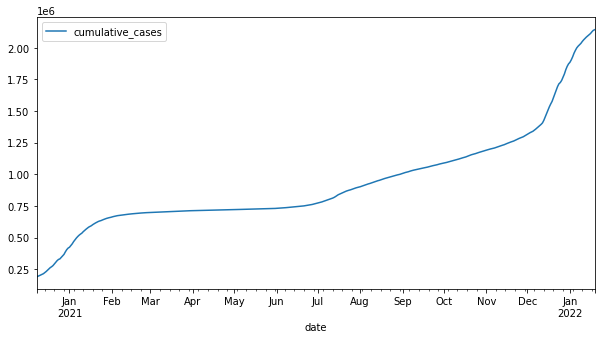

In [16]:
# Show the cumulative cases in London as they evolve through time.
# Question: Is there a period in time in which the cases plateaued?

# 1. Aggregate the data as an intermediate dataframe
cum_london = pd.DataFrame(covid_data[covid_data['area'] == 'London']['cumulative_cases'])
cum_london['date'] = covid_data[covid_data['area'] == 'London']['date']

# 2. Plot to visualised the transformed data
cum_london.plot(x='date', y='cumulative_cases', figsize = (10, 5))

# 3. Answer the question
# Yes, it can be seen that there is a plateau between the middle of January and the beginning of July for the cumulative cases in London.
# This means the cumulative cases remained almost the same in London during this period.

### **Task 16**

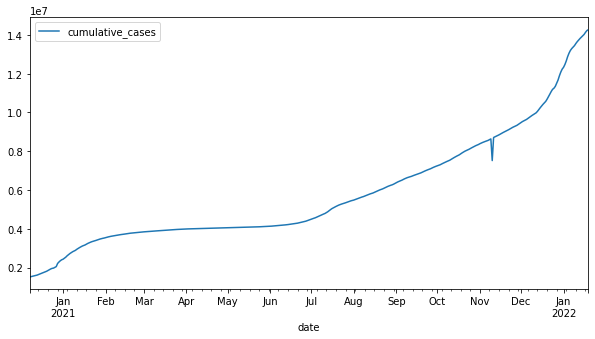

In [17]:
# Show the evolution through time of cumulative cases summed over all areas.
# Question: How does the pattern seen in London hold country-wide?

# 1. Aggregate the data as an intermediate dataframe
cum_sum = covid_data.groupby('date')['cumulative_cases'].sum().reset_index()

# 2. Plot to visualised the transformed data
cum_sum.plot(x='date', y='cumulative_cases', figsize = (10, 5))

# 3. Answer the question
# The pattern seen in London and the sum of all areas are similar for the cumulative cases. 
# Both of them reached a plateau in the middle of January of 2021, started increasing from July, and then reached their peak in early January, 2022.

### **Task 17**

area
East Midlands               AxesSubplot(0.125,0.125;0.775x0.755)
East of England             AxesSubplot(0.125,0.125;0.775x0.755)
London                      AxesSubplot(0.125,0.125;0.775x0.755)
North East                  AxesSubplot(0.125,0.125;0.775x0.755)
North West                  AxesSubplot(0.125,0.125;0.775x0.755)
Scotland                    AxesSubplot(0.125,0.125;0.775x0.755)
South East                  AxesSubplot(0.125,0.125;0.775x0.755)
South West                  AxesSubplot(0.125,0.125;0.775x0.755)
West Midlands               AxesSubplot(0.125,0.125;0.775x0.755)
Yorkshire and The Humber    AxesSubplot(0.125,0.125;0.775x0.755)
Name: cumulative_cases, dtype: object

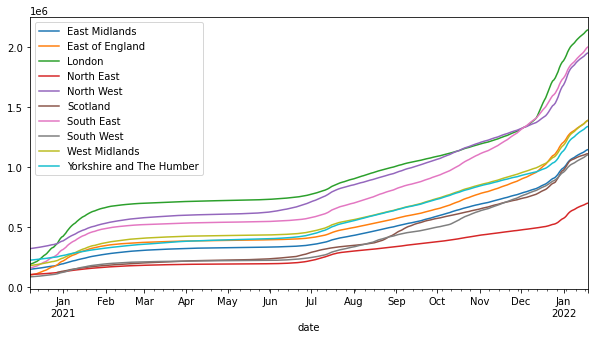

In [18]:
# Show us the evolution of cumulative cases of different areas as different lines in a plot.
# code from https://stackoverflow.com/questions/40071096/how-to-plot-multiple-lines-in-one-figure-in-pandas-python-based-on-data-from-mul
# Question: What patterns do all nations/regions share?

# 1. Aggregate the data as an intermediate dataframe
cum_by_area = covid_data[['date', 'area', 'cumulative_cases']]
cum_by_area = cum_by_area.set_index("date").groupby('area')['cumulative_cases']

# 2. Plot to visualised the transformed data
cum_by_area.plot(x='date', y='cumulative_cases', figsize = (10, 5), legend=True)


# 3. Answer the question
# Most of areas share similar patterns. Before January, the cumulative cases in most of areas did not change a lot
# while the cases in London increased significantly in the end of December, 2020. January-July of 2021, the cases in all areas plateaued.
# After July, the cumulative cases of all areas went up steadily while there was a noticeable increase in the middle of December and
# reached the peak in early January, 2022.

### **Task 18**

In [19]:
# Question: As a data scientist you will often need to interpret data insights, based on your own judgement and expertise. 
# Considering the data and plot from the last question, what event could have taken place in June-July that could justify the trend seen from there onward?

# 3. Answer the question
# There are some reasons that can explain why the cumulative cases remained the same in June-July but started increasing from the early July.
# One of the reason could be that students just leave school for summer vacation and go out everyday so public places become busy and
# crowded, which could cause the increase after July.
# Another reason could be the UK government removed most of the restrictions for stores, restaurants and pubs, and at the same time the European
# football season started. This implies more people go out, celebrate and eat in restaurants. That is why the cases went up.

### **Task 19**

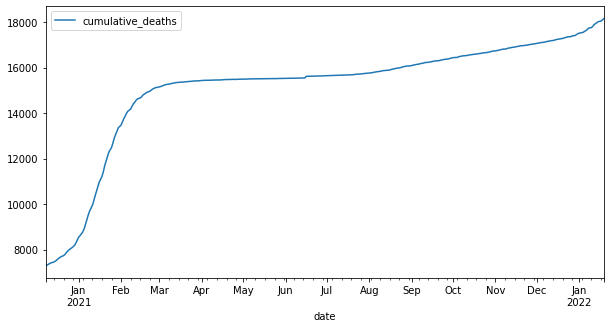

In [20]:
# Show us the evolution of cumulative deaths in London through time.
# Question: Is there a noticeable period in time when the ongoing trend is broken? When?

# 1. Aggregate the data as an intermediate dataframe
cum_d_london = pd.DataFrame(covid_data[covid_data['area'] == 'London']['cumulative_deaths'])
cum_d_london['date'] = covid_data[covid_data['area'] == 'London']['date']

# 2. Plot to visualised the transformed data
cum_d_london.plot(x='date', y='cumulative_deaths', figsize = (10, 5))

# 3. Answer the question
# Yes, between January and February of 2021 the cumulative deaths increased from 8000 to 15000 while the deaths stayed around 15000
# from the middle of February to August. After August, it shows an steady increase and the peak in January of 2022.

### **Task 20**

In [21]:
# Question: Based on the data and plot from the last question, is there any similarity between trends 
# in cumulative cases and cumulative deaths?

# 3. Answer the question
# Yes, both had a noticeable increase in January-February and then reached a plateau in the middle of February.
# Also, both cases and deaths started increasing again in July-August. The cumulative cases of London went up suddenly 
# in the middle of December while the deaths did not change a lot with the cases.

### **Task 21**

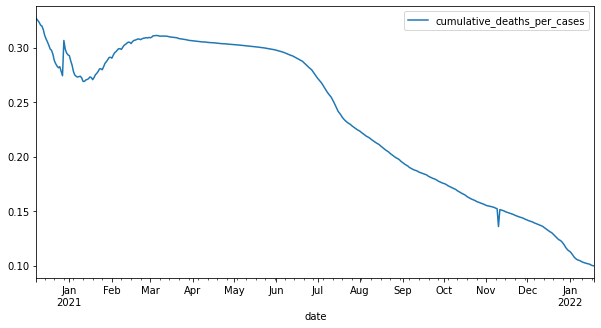

In [22]:
# Create a new column, cumulative deaths per cases, showing the ratio between cumu- lative deaths and cumulative cases in each row. Show us its sum over all regions/nations as a function of time.
# Question:  What overall trends can be seen?

# 1. Aggregate the data as an intermediate dataframe
per_cases = pd.DataFrame()
for i in range(len(covid_data)):
  per_cases.loc[i, 'cumulative_deaths_per_cases'] = covid_data.loc[i, 'cumulative_deaths']/covid_data.loc[i, 'cumulative_cases']
per_cases['date'] = covid_data['date']
per_cases['area'] = covid_data['area']

# 2. Plot to visualised the transformed data
per_cases.groupby('date')['cumulative_deaths_per_cases'].sum().reset_index().plot(x='date', y='cumulative_deaths_per_cases', figsize = (10, 5))

# 3. Answer the question
# It can be seen that the cumulative deaths per cases declined over time but it also shows that 
# there are increases in the beginning of January and February and this means there are two local
# valleys during that period.

### **Task 22**

In [23]:
# Question: Based on the data and plot from the last question, it seems like, 
#in June-July, the graph’s inclination gets steeper. What could be a reasonable explanation?

# 3. Answer the question
# The reason why the inclination become steeper in June-July is that during this period the cumulative cases rose while
# the cumulative deaths stayed almost the same. Because most people are fully vaccinated, the number of death did not go up along 
# with the increase in cases.

### **Task 23**

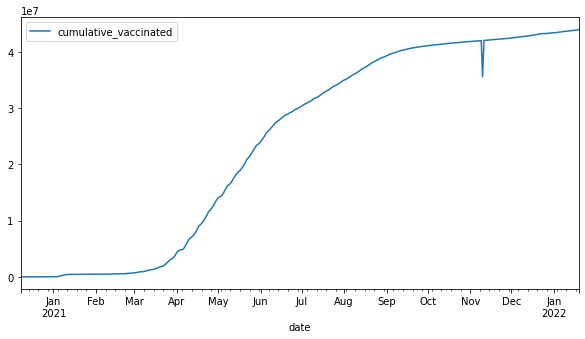

In [24]:
# Show us the sum of cumulative vaccinations over all areas as a function of time.
# Question: Are there any relationships between the trends seen here and the ones seen in Task 21?

# 1. Aggregate the data as an intermediate dataframe
cum_vac = covid_data.groupby('date')['cumulative_vaccinated'].sum().reset_index()

# 2. Plot to visualised the transformed data
cum_vac.plot(x='date', y='cumulative_vaccinated', figsize = (10, 5))

# 3. Answer the question
# Yes, when more people are vaccinated the death cases decreased. From this graph, it shows that 
# there is a steady increase for the cumulative vaccinated people from April, 2021. 
# About two months later, the cumulative_deaths_per_cases decreased and this can be seen in the graph of Task 21.

### **Task 24**

area
East Midlands               AxesSubplot(0.125,0.125;0.775x0.755)
East of England             AxesSubplot(0.125,0.125;0.775x0.755)
London                      AxesSubplot(0.125,0.125;0.775x0.755)
North East                  AxesSubplot(0.125,0.125;0.775x0.755)
North West                  AxesSubplot(0.125,0.125;0.775x0.755)
Scotland                    AxesSubplot(0.125,0.125;0.775x0.755)
South East                  AxesSubplot(0.125,0.125;0.775x0.755)
South West                  AxesSubplot(0.125,0.125;0.775x0.755)
West Midlands               AxesSubplot(0.125,0.125;0.775x0.755)
Yorkshire and The Humber    AxesSubplot(0.125,0.125;0.775x0.755)
Name: daily_cases_roll_avg, dtype: object

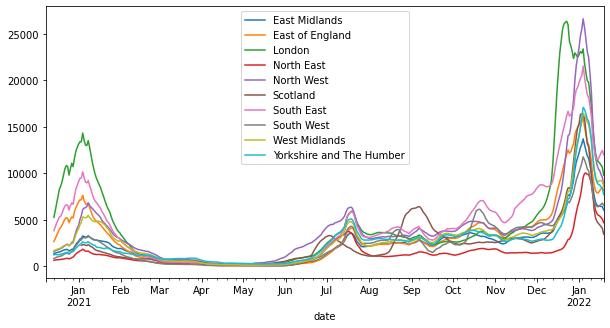

In [25]:
# Show us the daily cases rolling average as a function of time, separated by areas.
# Question: Is there a specific area that seems to escape the general trend in any way? Which one and how?

# 1. Aggregate the data as an intermediate dataframe
avg_by_area = covid_data[['date', 'area', 'daily_cases_roll_avg']]
avg_by_area = avg_by_area.set_index("date")

# 2. Plot to visualised the transformed data
avg_by_area.groupby('area')['daily_cases_roll_avg'].plot(x='date', y='daily_cases_roll_avg', figsize = (10, 5), legend=True)
# 3. Answer the question
# Yes, the daily cases in Scotland escape the general trend. It was following the trend from December of 2020
# but it went up and down between the end of June and July. For other areas, they had a increase after July. 
# Also, in early September, Scotland reached its local peak which is higher than the rest of regions, and then declined.
# During the same period, the changes in the daily cases rolling average for other areas are relatively small.

### **Task 25**

area
East of England    AxesSubplot(0.125,0.125;0.775x0.755)
Scotland           AxesSubplot(0.125,0.125;0.775x0.755)
Name: daily_cases_roll_avg, dtype: object

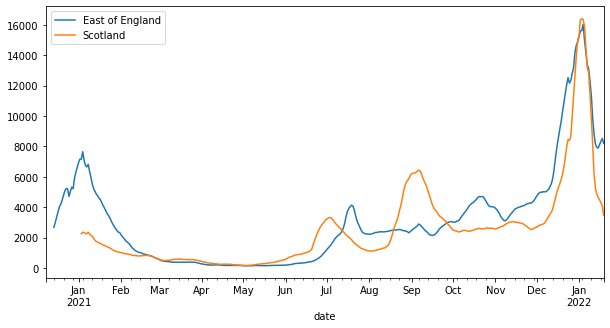

In [26]:
# Show us the daily cases rolling average as a function of time for the area identified in the previous question alongside another area that follows the general trend, in order to compare them.
# Question: What reasons there might be to justify this difference?

# 1. Aggregate the data as an intermediate dataframe
avg_by_area = covid_data[['date', 'area', 'daily_cases_roll_avg']]
two_areas = avg_by_area["area"].isin(['Scotland', 'East of England'])
avg_Scotland_East_England = avg_by_area[two_areas].set_index("date")

# 2. Plot to visualised the transformed data
avg_Scotland_East_England.groupby('area')['daily_cases_roll_avg'].plot(x='date', y='daily_cases_roll_avg', figsize = (10, 5), legend=True)

# 3. Answer the question
# We choose East of England to represent the general trend and compare Scotland with it.
# The graph of daily_cases_roll_avg shows that in Scotland, there is missing data before January of 2022, 
# and two local peaks are in the beginning of July and September. However, after January, the East of England has
# two local peaks in mid-January and mid-October. This tells us that Scotland reached the local peaks
# for "daily cases rolling average" before East of England. The reason for this difference could be that 
# the guidance or roadmap people follow and the time local governments ease the restriction are different.

### **Task 26**

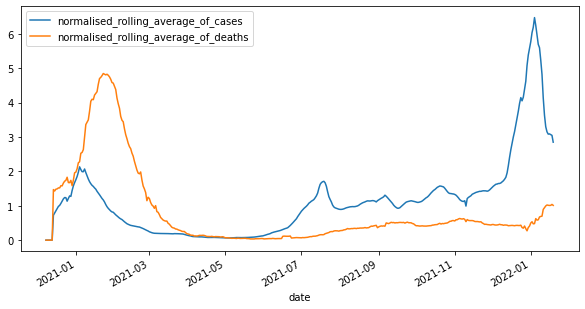

In [27]:
# Question: Are daily trends of cases and deaths increasing and decreasing at the same rates? What part of the plot tells you this?
# code from https://stackoverflow.com/questions/26785354/normalizing-a-list-of-numbers-in-python

# 1. Aggregate the data as an intermediate dataframe
norm_avg = pd.DataFrame()
for i in range(len(covid_data)):
  norm_avg.loc[i, 'daily_cases_roll_avg_norm'] = covid_data.loc[i, 'daily_cases_roll_avg']/covid_data['daily_cases_roll_avg'].max()
  norm_avg.loc[i, 'daily_deaths_roll_avg_norm'] = covid_data.loc[i, 'daily_deaths_roll_avg']/covid_data['daily_deaths_roll_avg'].max()
norm_avg['date'] = covid_data['date']
norm_avg['area'] = covid_data['area']

cum_norm_avg = pd.DataFrame()
for i in range(len(covid_data['date'])):
  cum_norm_avg.loc[i, 'normalised_rolling_average_of_cases'] = norm_avg[norm_avg['date'] == covid_data['date'][i]]['daily_cases_roll_avg_norm'].sum()
  cum_norm_avg.loc[i, 'normalised_rolling_average_of_deaths'] = norm_avg[norm_avg['date'] == covid_data['date'][i]]['daily_deaths_roll_avg_norm'].sum()
cum_norm_avg['date'] = covid_data['date']

# 2. Plot to visualised the transformed data
cum_norm_avg.plot(x='date', y=['normalised_rolling_average_of_cases', 'normalised_rolling_average_of_deaths'], figsize = (10, 5))

# 3. Answer the question
# No, the increase and decrease in daily trends of cases and deaths are not at the same rates. 
# The normalised rolling average of deaths increased from 0 to 5 in February and then it decreased to 0 
# in May and stayed around 0 to 0.5 till the end of 2021.
# However, compared to deaths, the normalised rolling average of cases has a smaller increase from 0 to 2 in January. 
# From June, it started going up and remained at around 1 for about five months but in the end of December the ceses jumped to about 6.5. 
# At the same time, the increase in the deaths is less than 1.

### **Task 27**

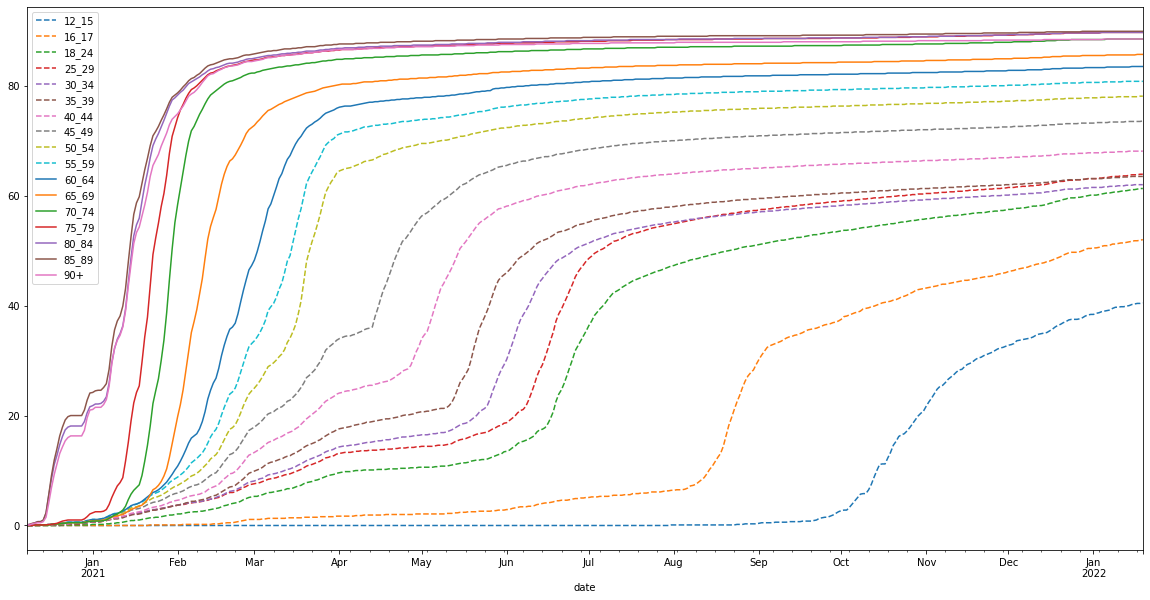

In [28]:
# Question: Were all age groups vaccinated equally and at the same time, or was there a strategy employed? What strategy does the plot indicate and why?
# code from https://stackoverflow.com/questions/39323002/convert-pandas-groupby-group-into-columns

# 1. Aggregate the data as an intermediate dataframe
london = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area'] == 'London']
london = london[['date','age','cumVaccinationFirstDoseUptakeByVaccinationDatePercentage']]
london = london.set_index(['date', 'age']).unstack()
london.columns = [i[1] for i in london.columns]

# 2. Plot to visualised the transformed data
london.plot(style=['--' for _ in range(10)], legend=True, figsize = (20, 10))

# 3. Answer the question
# No, people in different age groups are vaccinated at different time. Older adults have the priority to get the vaccines.
# We can see that 20 percent of people over 80 got their first does before January, 2021 
# and about 70 percent of people over 60 received their first vaccine before mid-March.
# For people aged between 18 and 60, more than half of they got their first dose bewtween April and July.
# The reason why older people have the priority is that older people are more likely to die, 
# and if they are severely ill, they need more time to recover from coronavirus.
# Therefore, if they can be vaccinated first then more suffering could be relieved and more lives could be saved.

### **Task 28**

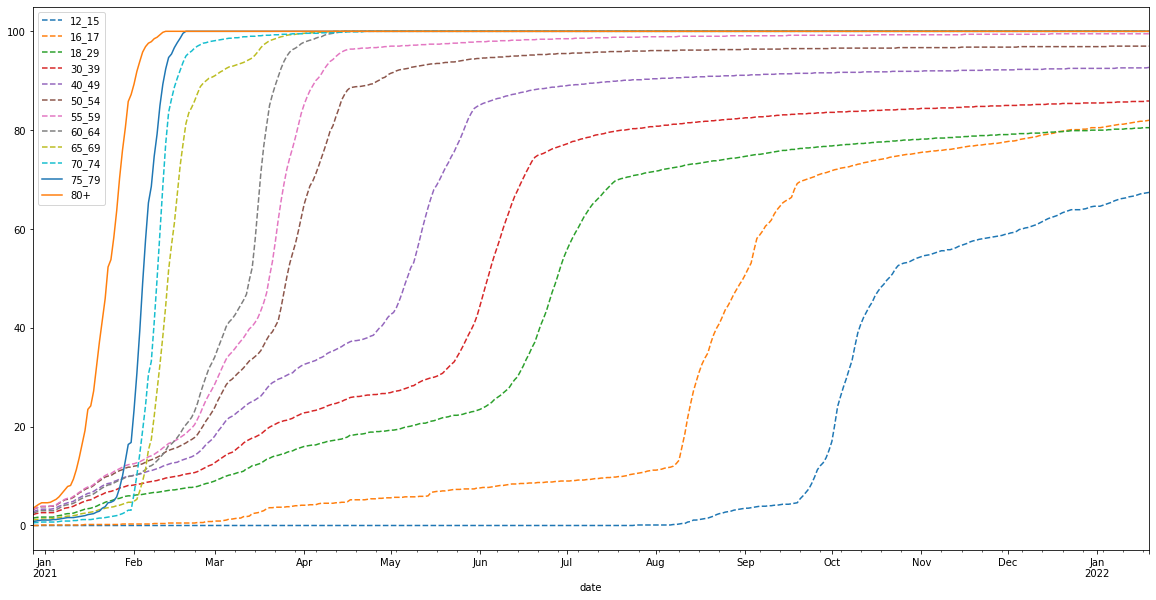

In [29]:
# Question: In both plots, compare how vaccination evolved for two sections of population: 50-64 years and 65-79 years. 
# Were there any differences in the strategies employed between London and Scotland for dealing with both sections?
# code from https://stackoverflow.com/questions/28293028/plotting-grouped-data-in-same-plot-using-pandas
# code from https://stackoverflow.com/questions/61585307/change-column-names-in-python-pandas-using-list-comprehension

# 1. Aggregate the data as an intermediate dataframe
scotland = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area'] == 'Scotland']
scotland = scotland[['date','age','cumVaccinationFirstDoseUptakeByVaccinationDatePercentage']]
scotland = scotland.set_index(['date', 'age']).unstack()
scotland.columns = [i[1] for i in scotland.columns]

# 2. Plot to visualised the transformed data
scotland.plot(style=['--' for _ in range(10)], legend=True, figsize = (20, 10))

# 3. Answer the question
# Yes, the strategy for vaccination are different between London and Scotland.
# We can see that in Scotland, over 90 percent of people in the section of 65-79 years old got their first does in early February
# while less than 80 percent of people in the same section are vaccined at the same time in London. Same as the section of 50-64.
# 80 percent of people in 50-64 got their vaccines in March in Scotland but less that 70 percent of people in the same age group
# have vaccination in London.

# In London, the strategy is that the target percentage of people vaccinated in each age group is different so for the group in 50-64
# years old the percentage is around 65 percent, and 75 percent for people in 65-79. Once the percentage is achieved in the prior age group,
# more vaccines are given to the next age group. However, the strategy is totally different in Scotland.
# Scotland government wants all of people in the same age section to get vaccines at the same time. Therefore, they wait till 100 percent
# of people in 65-79 are vaccinated and then give more vaccines to the next group, age 50-64.